In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


---
## Диагностика моделей классификации

Для первого примера воспользуемся синтетическими данными. Сгенерируем большой и достаточно сложный датасет для классификации. В нем будет 10 тысяч точек и 500 атрибутов. Из них всего 50 признаков будут информативными. Сразу после генерации разделим получившийся датасет на обучающую и тестовую выборки:


In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=10000,
    n_features=500,
    n_informative=50,
    n_repeated=0,
    class_sep=1,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=3
)


Обучим на этом наборе данных самую простую модель - логистическую регрессию. Выведем оценки точности этой модели на обучающей и тестовой выборке:


In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train, y_train)


В данном случае мы используем метрику эффективности классификации по умолчанию. В зависимости от задания вы можете проводить анализ по любой интересующей вас метрике. Получаем такие оценки эффективности данной модели:


In [6]:
print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")


Training score: 0.8413
Test score: 0.8056


То, насколько отличается обучающая и тестовая эффективность модели - основной индикатор пере- или недообучения. Мы явно видим, что тестовая эффективность полученной модели неидеальна. Определить, что является причиной снижения качества модели - ее излишняя или недостаточная вариативность - основная цель диагностики модели машинного обучения.

Но по одним этим показателям очень сложно понять, в какой из двух ситуаций мы находимся. Поэтому прибегнем к построению кривых обучения. Это даст нам больше информации о том, каков уровень сложности модели по отношению к данным. Воспользуемся готовой реализацией построения кривых обучения из библиотеки продвинутой визуализации для машинного обучения yellowbrick:


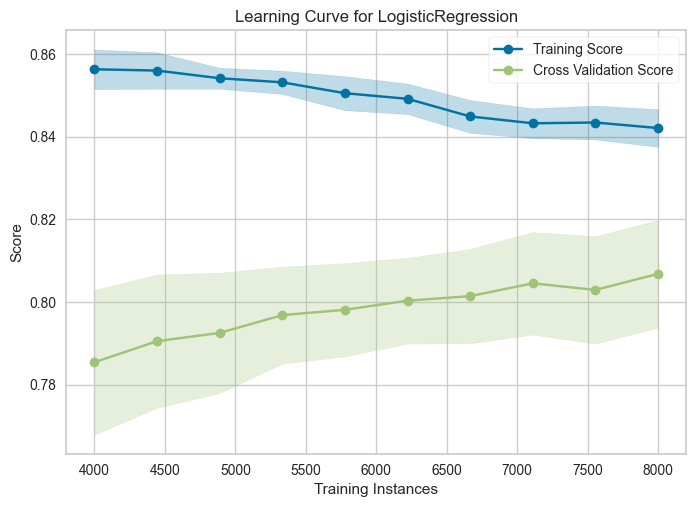

In [8]:
from yellowbrick.model_selection import LearningCurve

visualizer = (
    LearningCurve(LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10))
    .fit(X, y)
    .show()
)


Здесь мы задаем модель, которую хотим проверить и набор долей обучающей выборки, по которым будем ее обучать. В данном случае, эта функция построит модели логистической регрессии, обученные на 10%, 20%, и так далее до 100% обучающей выборки. А затем по каждой модели будет вычислена обучающая и тестовая эффективности. И эти показатели будут изображены на графике, то есть кривой обучения:

---


Эта кривая показывает, что когда модель учится на небольшом объеме данных, она имеет прекрасную обучающую эффективность, но плохую тестовую. По мере увеличения объема обучающей выборки, эти эффективности сближаются, но между ними все еще сохраняется зазор.

Напомним, что большой промежуток между тестовой и обучающей эффективностью свидетельствует о переобучении. А низкое значение обучающей эффективности - о недообучении. Так что из этого присутствует в данной модели? Можно предположить, что модель немного переобучается. В пользу этого говорит и то, что наш исходный датасет очень разреженный (хотя мы об этом знаем только потому, что его сгенерировали). Более точно можно будет сказать сравнив эту модель с другими. Самый простой способ - использовать регуляризацию.

МЫ воспользуемся классификатором на основе гребневой регрессии. Вспомним, что обычный метод наименьших квадратов (воплощением которого является модель логистической регрессии) эквивалентна гребневой модели с параметром регуляризации, равном нулю. Чем больше этот параметр, тем больше регуляризации в модели и тем проще получаемые модели. Если мы предполагаем, что наша исходная модель переобучалась, то давайте построим и оценим модель с большим значением параметра регуляризации:


In [10]:
from sklearn.linear_model import RidgeClassifier

lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)


При таком огромном значении регуляризации мы почти гарантированно получим недообученную модель. Поэтому полезно будет сравнить результаты модели выше с этими. Вот что получилось у очень регуляризованной модели:


In [11]:
print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")


Training score: 0.7724
Test score: 0.7712


Обратите внимание, что эффективность стала заметно ниже. Плюс, значения почти совпадают. То есть, почти никакой разницы не осталось. Это подтверждает наш первоначальный вывод о том, что в первой модели разница между обучающей и тестовой эффективностью получилась довольно большой для данной задачи. Построим кривые обучения для нашей второй модели:

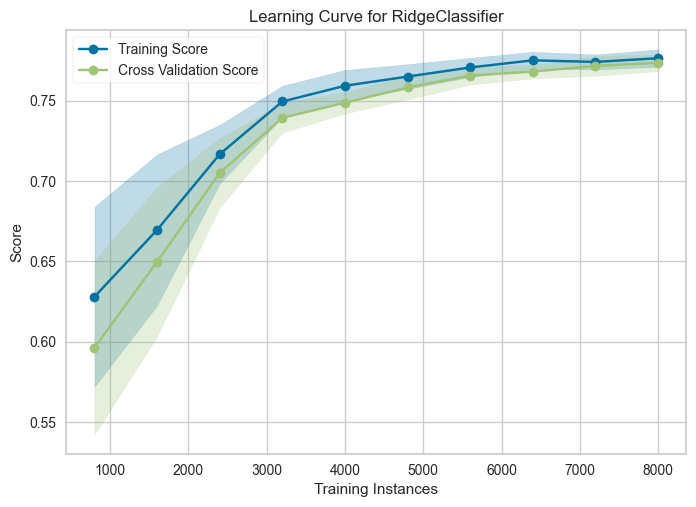

In [12]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y).show()

Получилась совсем другая картина

При анализе таких графиков надо обязательно обращать внимание на масштаб вертикальной оси. Несмотря на то, что кажется, будто значения в правой части графика (а нам интересны в первую очередь именно конечные значения эффективности, остальные - это просто предыстория) сильно больше, чем на первом, на самом деле они ниже. Данный график очень характерен для недообучения - низкие значения эффективности и практически никакой разницы между тестовой и обучающей эффективностью.

Если нерегуляризованная модель переобучается, а регуляризованная - недообучается, то где-то в промежутке есть оптимальная модель

Для того, чтобы проанализировать данную задачу еще более глубоко построим график зависимости эффективности модели от значения параметра регуляризации. Для этого воспользуется логравномерным распределением:

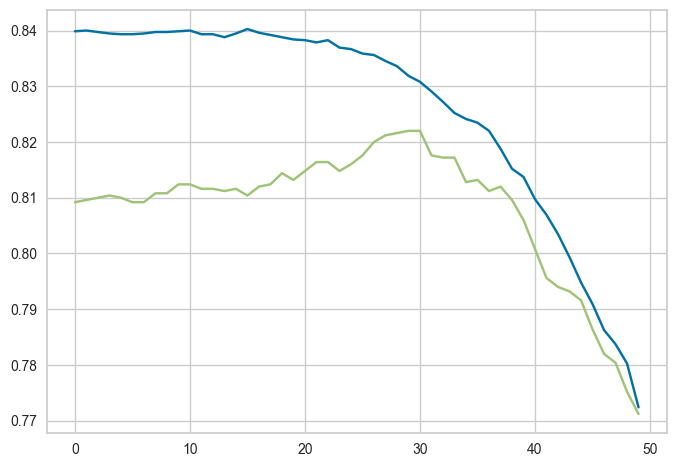

In [13]:
from sklearn.linear_model import RidgeClassifier

trains = []
tests = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)


Данный код построит 50 моделей, различающихся только параметром регуляризации. Он будет лежать в диапазоне от 100 ($10^2$) до 1 000 000 ($10^6$). Диапазон подбирается эмпирически, интересующий нас интервал значений параметров регуляризации будет разный в других задачах. Поэтому рекомендуется сначала построить модели в очень широких пределах (скажем, от -6 до 6), а затем сужать его настолько, чтобы на графике наглядно проявилась примерно такая картина

Здесь мы видим, что при определенных значениях параметра регуляризации тестовая эффективность модели (а нас в конечном итоге интересует именно она) лучше, чем во всех остальных. Подбором или алгоритмически можно найти такое оптимальное значение параметра регуляризации. Оно дает нам модель, которая имеет оптимальный уровень сложности для данного конкретного датасета. Давайте выведем получившиеся показатели:

In [14]:
from sklearn.linear_model import RidgeClassifier

lr = RidgeClassifier(alpha=26500).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")


Training score: 0.8311
Test score: 0.8228


Эта модель получилась немного лучше, чем самая первая, модель логистической регрессии

Это произошло потому, что мы за счет регуляризации убрали негативный эффект переобучения. Давайте построим кривые обучения, чтобы посмотреть, как они выглядят для "хорошей" модели:

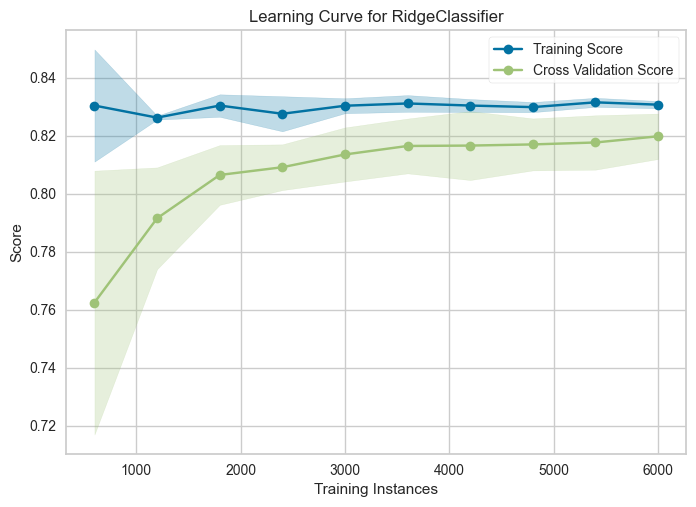

In [15]:
visualizer = (
    LearningCurve(RidgeClassifier(alpha=26500), train_sizes=np.linspace(0.1, 1.0, 10))
    .fit(X_train, y_train)
    .show()
)


Опять же, с оглядкой на масштаб вертикальной оси мы видим, что и уровень эффективности выше, чем в первой модели и разница между двумя эффективностями тоже сократилась. И то и другое - это свидетельство большей обобщающей способности модели.

---
## Диагностика моделей регрессии

Для более реалистичного примера загрузим датасет цен на недвижимость:

In [16]:
from numpy import genfromtxt

dataset = genfromtxt(
    "https://raw.githubusercontent.com/m-mehdi/tutorials/main/boston_housing.csv",
    delimiter=",",
)
X = dataset[:, :-1]
y = dataset[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)


Это набор данных для решения задачи регрессии - предсказания цен объектов недвижимости по их характеристикам. Самостоятельно изучите данный датасет, приведите его численные показатели. А мы сразу выведем оценку эффективности простой модели - линейной регрессии:

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [18]:
model = LinearRegression().fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [27]:
print("Linear Regression-Training set score", round(r2_score(y_pred_train, y_train), 3))
print("Linear Regression-Test set score", round(r2_score(y_pred_test, y_test), 3))

Linear Regression-Training set score 0.95
Linear Regression-Test set score 0.667


Большой разрыв между обучающей и тестовой эффективностью также сразу должен навести на мысль о переобучении данной модели. Попробуем проверить наше предположение при помощи кривых обучения (обратите внимание, что мы сразу используем гребневую модель с очень маленькой регуляризацией):